## Imports

In [ ]:
# Install dependencies
!pip install -q tensorflow matplotlib opencv-python gradio
!pip install ultralytics  # Install YOLOv8


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm
import matplotlib.pyplot as plt

## Dataset

### Upload Dataset

In [ ]:
# To get data locally
from google.colab import files

uploaded = files.upload()

!unzip -q PeopleArt.zip -d /content/


Saving PeopleArt.zip to PeopleArt.zip


In [ ]:
# # To get data from github
# !git clone https://github.com/BathVisArtData/PeopleArt.git

### Parse XML and convert to YOLO format

In [ ]:
# convert
import os
import xml.etree.ElementTree as ET
from PIL import Image

# Paths
annotation_dir = '/content/PeopleArt/Annotations'
image_dir = '/content/PeopleArt/JPEGImages'
output_label_dir = '/content/PeopleArt/labels'
output_image_dir = '/content/PeopleArt/images'

os.makedirs(output_label_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)

def convert_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    return (x*dw, y*dh, w*dw, h*dh)

# Loop through all styles and annotations
for style in os.listdir(annotation_dir):
    style_path = os.path.join(annotation_dir, style)
    if not os.path.isdir(style_path):
        continue
    for file in os.listdir(style_path):
        if not file.endswith('.xml'):
            continue
        xml_path = os.path.join(style_path, file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        image_filename = root.find('filename').text
        image_subfolder = style
        image_path = os.path.join(image_dir, image_subfolder, image_filename)

        # Skip if image does not exist
        if not os.path.exists(image_path):
            continue

        im = Image.open(image_path)
        width, height = im.size

        label_lines = []

        for obj in root.findall('object'):
            cls = obj.find('name').text
            if cls != "person":
                continue
            xmlbox = obj.find('bndbox')
            box = [int(xmlbox.find(tag).text) for tag in ('xmin', 'ymin', 'xmax', 'ymax')]
            bbox = convert_bbox((width, height), box)
            label_lines.append(f"0 {' '.join([f'{a:.6f}' for a in bbox])}")

        # Write label file
        label_filename = os.path.splitext(image_filename)[0] + '.txt'
        with open(os.path.join(output_label_dir, label_filename), 'w') as f:
            f.write('\n'.join(label_lines))

        # Copy image to new folder
        im.save(os.path.join(output_image_dir, image_filename))


### Prepare Dataset (Train and Validation sets)

In [ ]:
import os
import random
import shutil

# Paths
images_path = "/content/PeopleArt/images"
labels_path = "/content/PeopleArt/labels"

# Output folders
base = "/content/PeopleArt"
for split in ['train', 'val', 'test']:
    os.makedirs(f"{base}/images/{split}", exist_ok=True)
    os.makedirs(f"{base}/labels/{split}", exist_ok=True)

# Gather all files
all_images = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
random.shuffle(all_images)

# Split
n_total = len(all_images)
n_train = int(0.7 * n_total)
n_val = int(0.2 * n_total)
n_test = n_total - n_train - n_val

splits = {
    'train': all_images[:n_train],
    'val': all_images[n_train:n_train+n_val],
    'test': all_images[n_train+n_val:]
}

# Move files
for split, files in splits.items():
    for img in files:
        label = img.replace('.jpg', '.txt')
        shutil.copy(os.path.join(images_path, img), f"{base}/images/{split}/{img}")
        shutil.copy(os.path.join(labels_path, label), f"{base}/labels/{split}/{label}")


### Load Dataset

In [ ]:
def load_data(img_dir, label_dir, img_size=(224, 224)):
    X, y = [], []

    for fname in os.listdir(img_dir):
        if not fname.endswith('.jpg'): continue

        image_path = os.path.join(img_dir, fname)
        label_path = os.path.join(label_dir, fname.replace('.jpg', '.txt'))

        image = cv2.imread(image_path)
        image = cv2.resize(image, img_size)
        image = image / 255.0

        if not os.path.exists(label_path): continue
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                cls, x_center, y_center, w, h = map(float, line.strip().split())
                bbox = [x_center, y_center, w, h]  # Already normalized
                X.append(image)
                y.append(bbox)

    return np.array(X), np.array(y)


In [ ]:
train_images, train_bboxes = load_data(
    img_dir="/content/PeopleArt/images/train",
    label_dir="/content/PeopleArt/labels/train"
)

val_images, val_bboxes = load_data(
    img_dir="/content/PeopleArt/images/val",
    label_dir="/content/PeopleArt/labels/val"
)

test_images, test_bboxes = load_data(
    img_dir="/content/PeopleArt/images/test",
    label_dir="/content/PeopleArt/labels/test"
)

### Verify Splits

In [ ]:
import os

base_path = "/content/PeopleArt/images"

print("Images samples:")
for split in ['train', 'val', 'test']:
    num_images = len([f for f in os.listdir(f"{base_path}/{split}") if f.endswith('.jpg')])
    print(f"{split.capitalize()} set: {num_images} images")

base_labels = "/content/PeopleArt/labels"

print("Labels samples:")
for split in ['train', 'val', 'test']:
    num_labels = len([f for f in os.listdir(f"{base_labels}/{split}") if f.endswith('.txt')])
    print(f"{split.capitalize()} set: {num_labels} labels")

Images samples:
Train set: 1011 images
Val set: 289 images
Test set: 145 images
Labels samples:
Train set: 1011 labels
Val set: 289 labels
Test set: 145 labels


## Model

YOLO MODEL

In [ ]:
data_yaml = """
# peopleart.yaml
path: /content/PeopleArt
train: images/train
val: images/val
test: images/test

nc: 1  # Number of classes (just "person")
names: ["person"]  # Class names
"""

with open('/content/PeopleArt/data.yaml', 'w') as f:  # Save in dataset root
    f.write(data_yaml)

### Train Model

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load model
model = YOLO("yolov8m.pt")  # or yolov8s.pt

# Unfreeze strategy (better implementation)
def unfreeze_layers(model, num_layers=10):
    """Unfreeze last N layers of YOLOv8"""
    layers = list(model.model.named_parameters())
    for i, (name, param) in enumerate(layers[-num_layers:]):  # Last N layers
        param.requires_grad = True
        print(f"Unfrozen: {name}")

unfreeze_layers(model, num_layers=15)  # Unfreeze last 15 layers

# Training with proper settings
results = model.train(
    data="/content/PeopleArt/data.yaml",
    epochs=50,
    imgsz=896 or 1024,
    batch=16,
    optimizer="Adam",
    lr0=1e-4,  # Lower LR for fine-tuning
    resume=False,  # MUST BE FALSE FOR NEW TRAINING
    augment=True,  # Mosaic/MixUp
    overlap_mask=True,
    copy_paste=0.3,  # Lower value for person detection
    patience=10,  # Early stopping
    device=0  # Use GPU
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 182MB/s]


Unfrozen: model.22.cv3.1.0.bn.bias
Unfrozen: model.22.cv3.1.1.conv.weight
Unfrozen: model.22.cv3.1.1.bn.weight
Unfrozen: model.22.cv3.1.1.bn.bias
Unfrozen: model.22.cv3.1.2.weight
Unfrozen: model.22.cv3.1.2.bias
Unfrozen: model.22.cv3.2.0.conv.weight
Unfrozen: model.22.cv3.2.0.bn.weight
Unfrozen: model.22.cv3.2.0.bn.bias
Unfrozen: model.22.cv3.2.1.conv.weight
Unfrozen: model.22.cv3.2.1.bn.weight
Unfrozen: model.22.cv3.2.1.bn.bias
Unfrozen: model.22.cv3.2.2.weight
Unfrozen: model.22.cv3.2.2.bias
Unfrozen: model.22.dfl.conv.weight
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/PeopleArt/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embe

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

 18                  -1  2   1846272  ultralytics.nn.modules.block.C2f             [576, 384, 2]                 
 19                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960, 576, 2]                 
 22        [15, 18, 21]  1   3776275  ultralytics.nn.modules.head.Detect           [1, [192, 384, 576]]          
Model summary: 169 layers, 25,856,899 parameters, 25,856,883 gradients, 79.1 GFLOPs

Transferred 469/475 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 88.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1155.5±388.0 MB/s, size: 32.2 KB)


train: Scanning /content/PeopleArt/labels/train... 1011 images, 94 backgrounds, 0 corrupt: 100%|██████████| 1011/1011 [00:00<00:00, 2548.97it/s]


train: New cache created: /content/PeopleArt/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 569.0±290.9 MB/s, size: 30.5 KB)


val: Scanning /content/PeopleArt/labels/val... 289 images, 31 backgrounds, 0 corrupt: 100%|██████████| 289/289 [00:00<00:00, 1229.92it/s]

val: New cache created: /content/PeopleArt/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 896 train, 896 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.6G      1.387      1.778      1.682          9        896: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]

                   all        289        707      0.467      0.414      0.402       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.5G      1.335      1.382      1.613         14        896: 100%|██████████| 64/64 [01:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        289        707       0.62      0.556      0.588      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.7G      1.268       1.23      1.572          8        896: 100%|██████████| 64/64 [01:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        289        707      0.649      0.583      0.576       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.7G      1.223      1.168      1.549         21        896: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

                   all        289        707      0.673       0.59      0.632      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.7G       1.18      1.136      1.521         14        896: 100%|██████████| 64/64 [01:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        289        707      0.725      0.586      0.674      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.6G      1.163      1.084      1.512         14        896: 100%|██████████| 64/64 [01:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

                   all        289        707      0.733      0.567      0.629      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.7G      1.145      1.022      1.486         11        896: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        289        707      0.641       0.61      0.612      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.7G      1.137     0.9891       1.48         22        896: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        289        707      0.675      0.622      0.656      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.6G      1.098     0.9126      1.432         17        896: 100%|██████████| 64/64 [01:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        289        707      0.698      0.612      0.682      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.7G       1.08     0.8747      1.429          9        896: 100%|██████████| 64/64 [01:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

                   all        289        707      0.648      0.613      0.633      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.7G      1.064     0.8917      1.409         18        896: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        289        707      0.676      0.635      0.658      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      11.6G      1.032     0.8382      1.384          6        896: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        289        707      0.693      0.554      0.632      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      11.7G      1.049     0.8206      1.393         16        896: 100%|██████████| 64/64 [01:03<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        289        707      0.696      0.618      0.639      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.6G      1.006     0.7631      1.353         23        896: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        289        707      0.656       0.64      0.662      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.7G     0.9858     0.7717      1.355         14        896: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

                   all        289        707      0.636      0.622      0.597      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      11.7G     0.9728     0.7653      1.347         14        896: 100%|██████████| 64/64 [01:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

                   all        289        707      0.755      0.591      0.679      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.7G     0.9552     0.7408      1.317         11        896: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        289        707      0.714      0.605      0.666      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.7G     0.9346     0.6903      1.302          7        896: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        289        707      0.712      0.562      0.638      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.6G     0.9336     0.6557      1.287         22        896: 100%|██████████| 64/64 [01:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

                   all        289        707      0.724      0.601      0.664      0.394
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 9, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



19 epochs completed in 0.402 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


                   all        289        707       0.71      0.632      0.711      0.444
Speed: 0.4ms preprocess, 40.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train


### Validate Model

In [ ]:
metrics = model.val(split='val', plots=True)

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 869.5±308.4 MB/s, size: 27.7 KB)


val: Scanning /content/PeopleArt/labels/val.cache... 289 images, 31 backgrounds, 0 corrupt: 100%|██████████| 289/289 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:24<00:00,  1.31s/it]


                   all        289        707       0.72      0.634      0.714      0.447
Speed: 1.2ms preprocess, 78.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train2


### Display Results

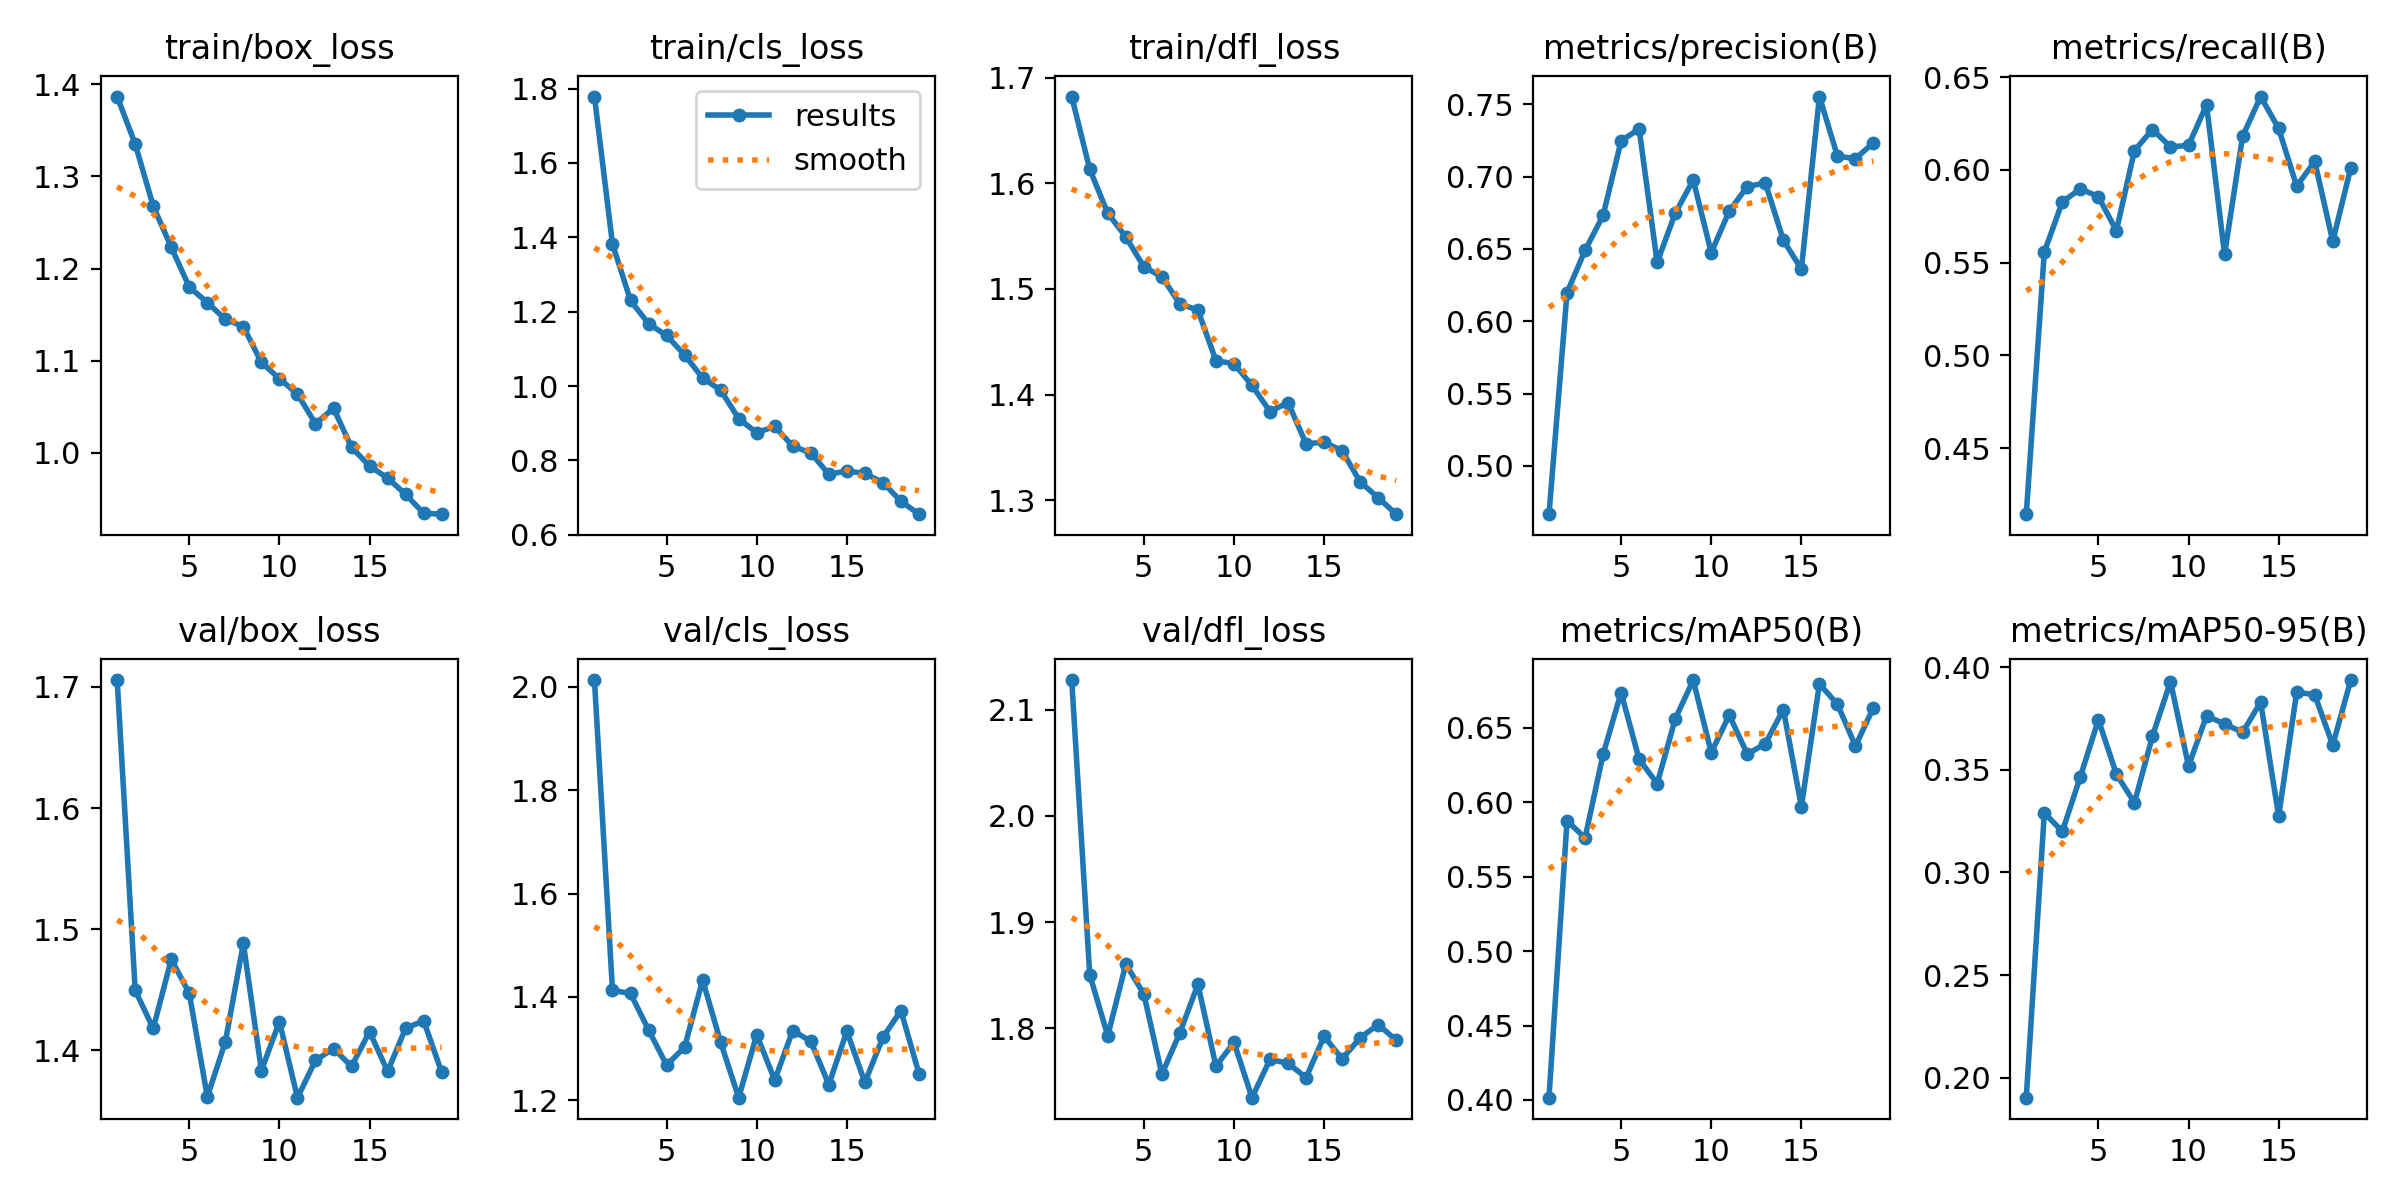

In [ ]:
# Display training curves
from IPython.display import Image
Image(filename=f"{model.trainer.save_dir}/results.png")

### Show Predictions

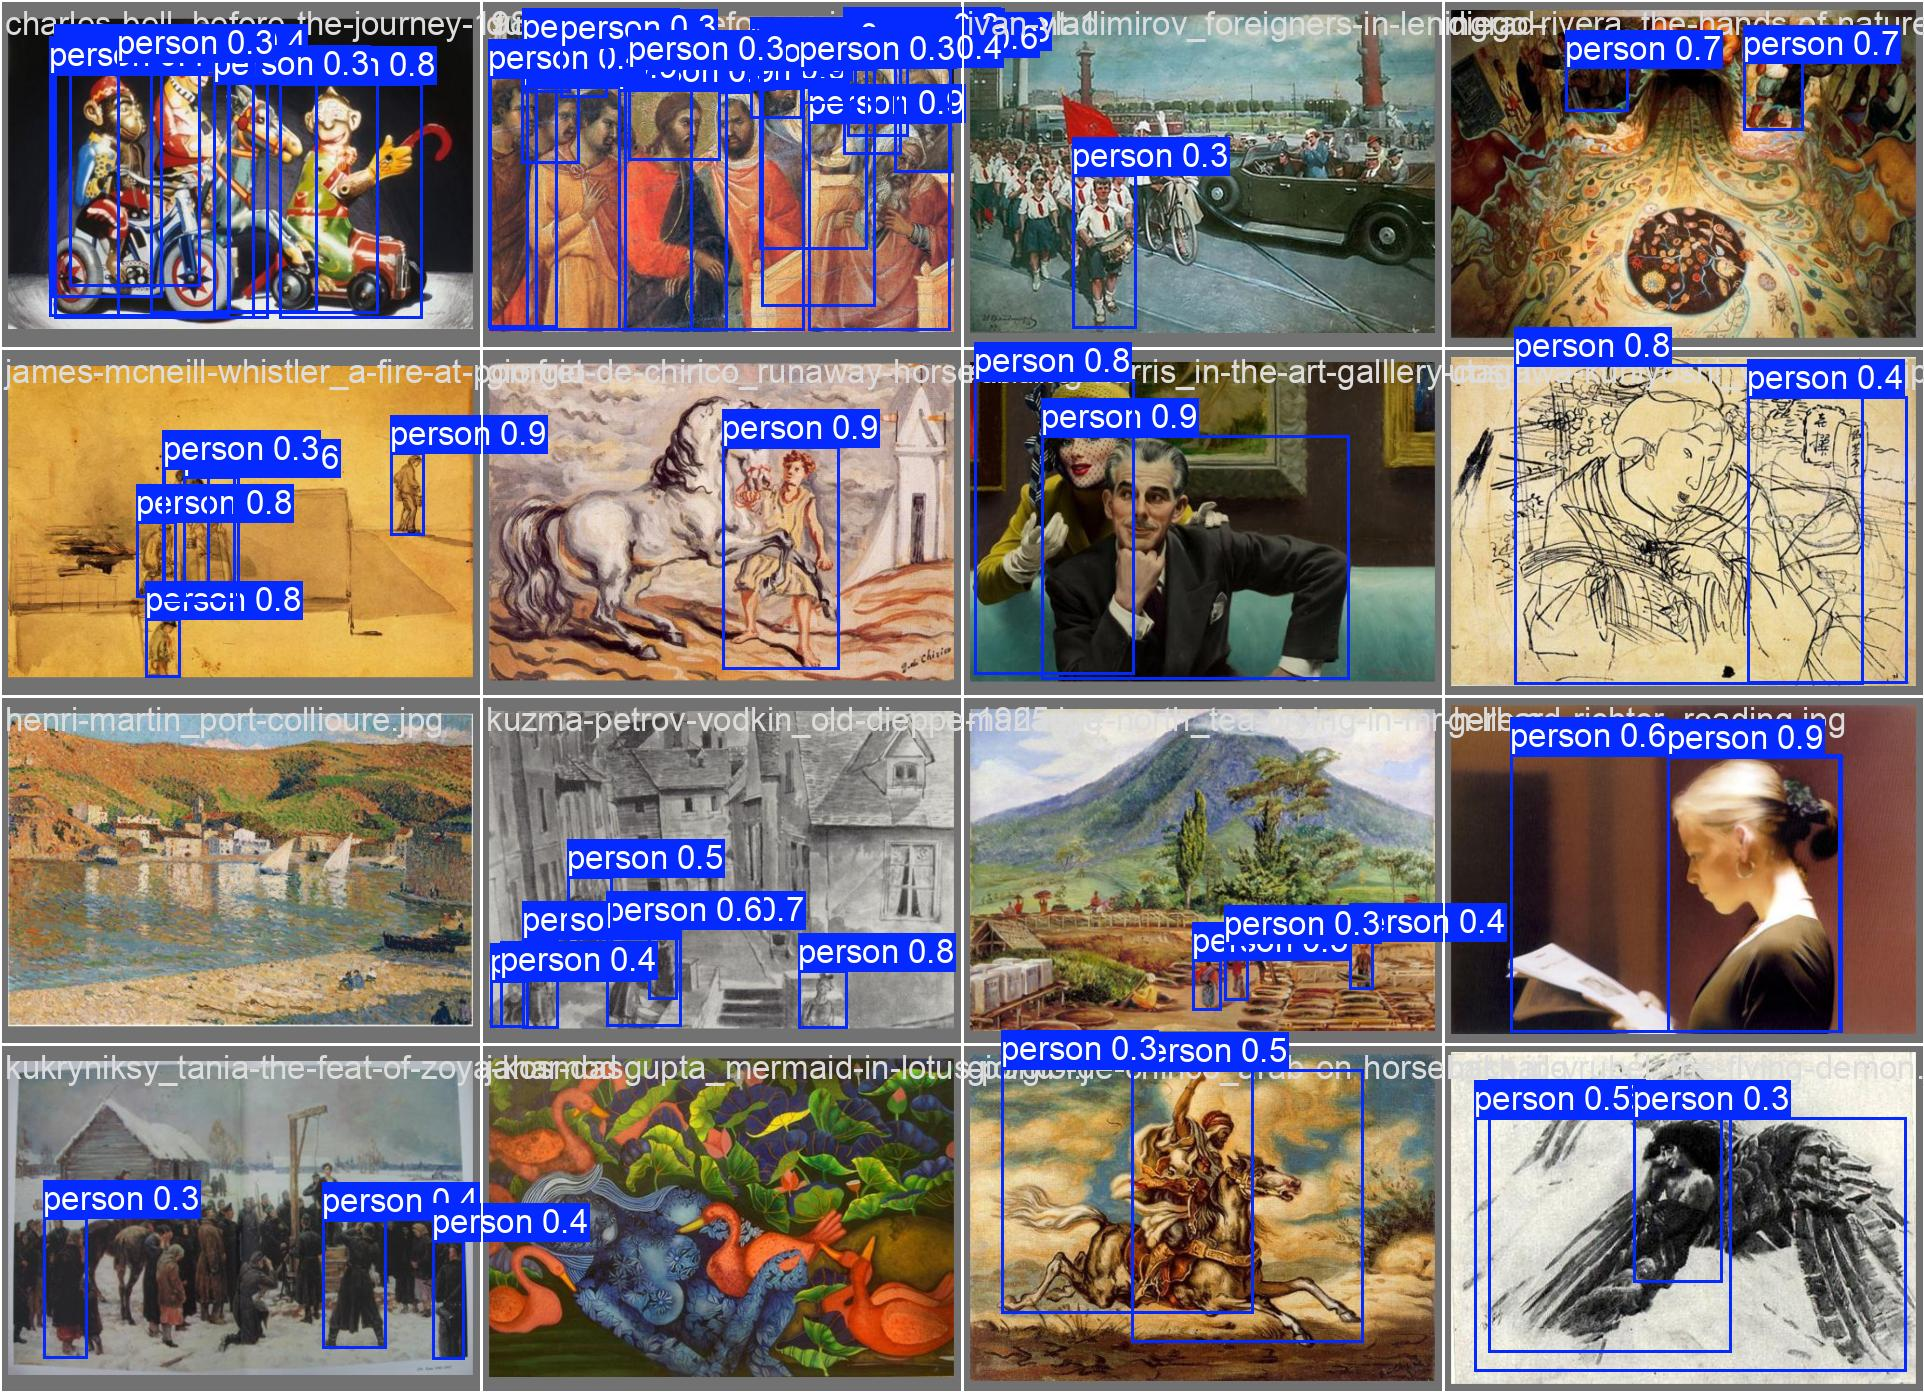

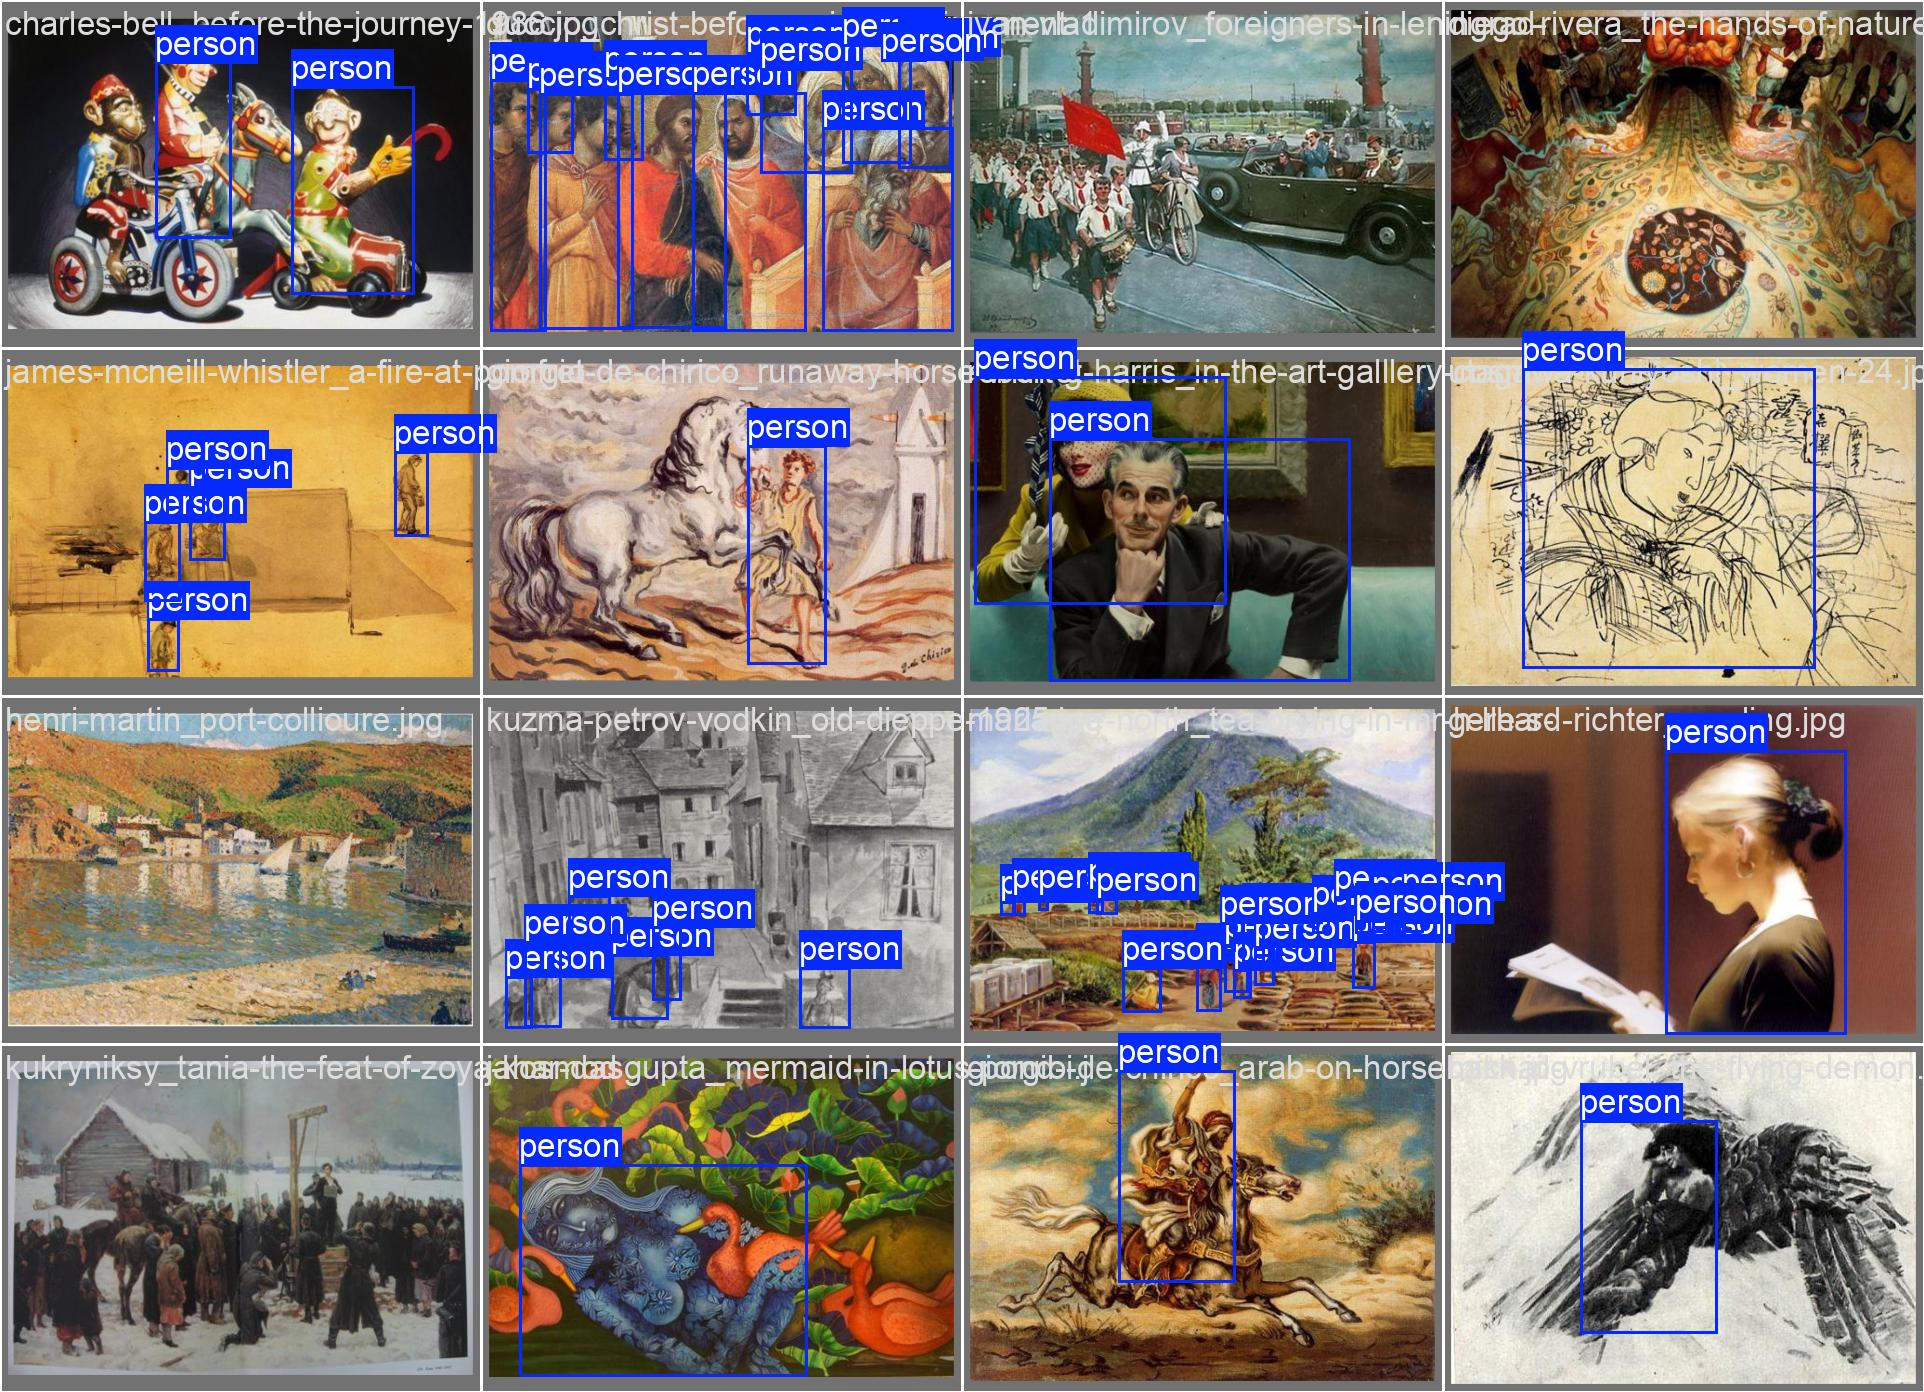

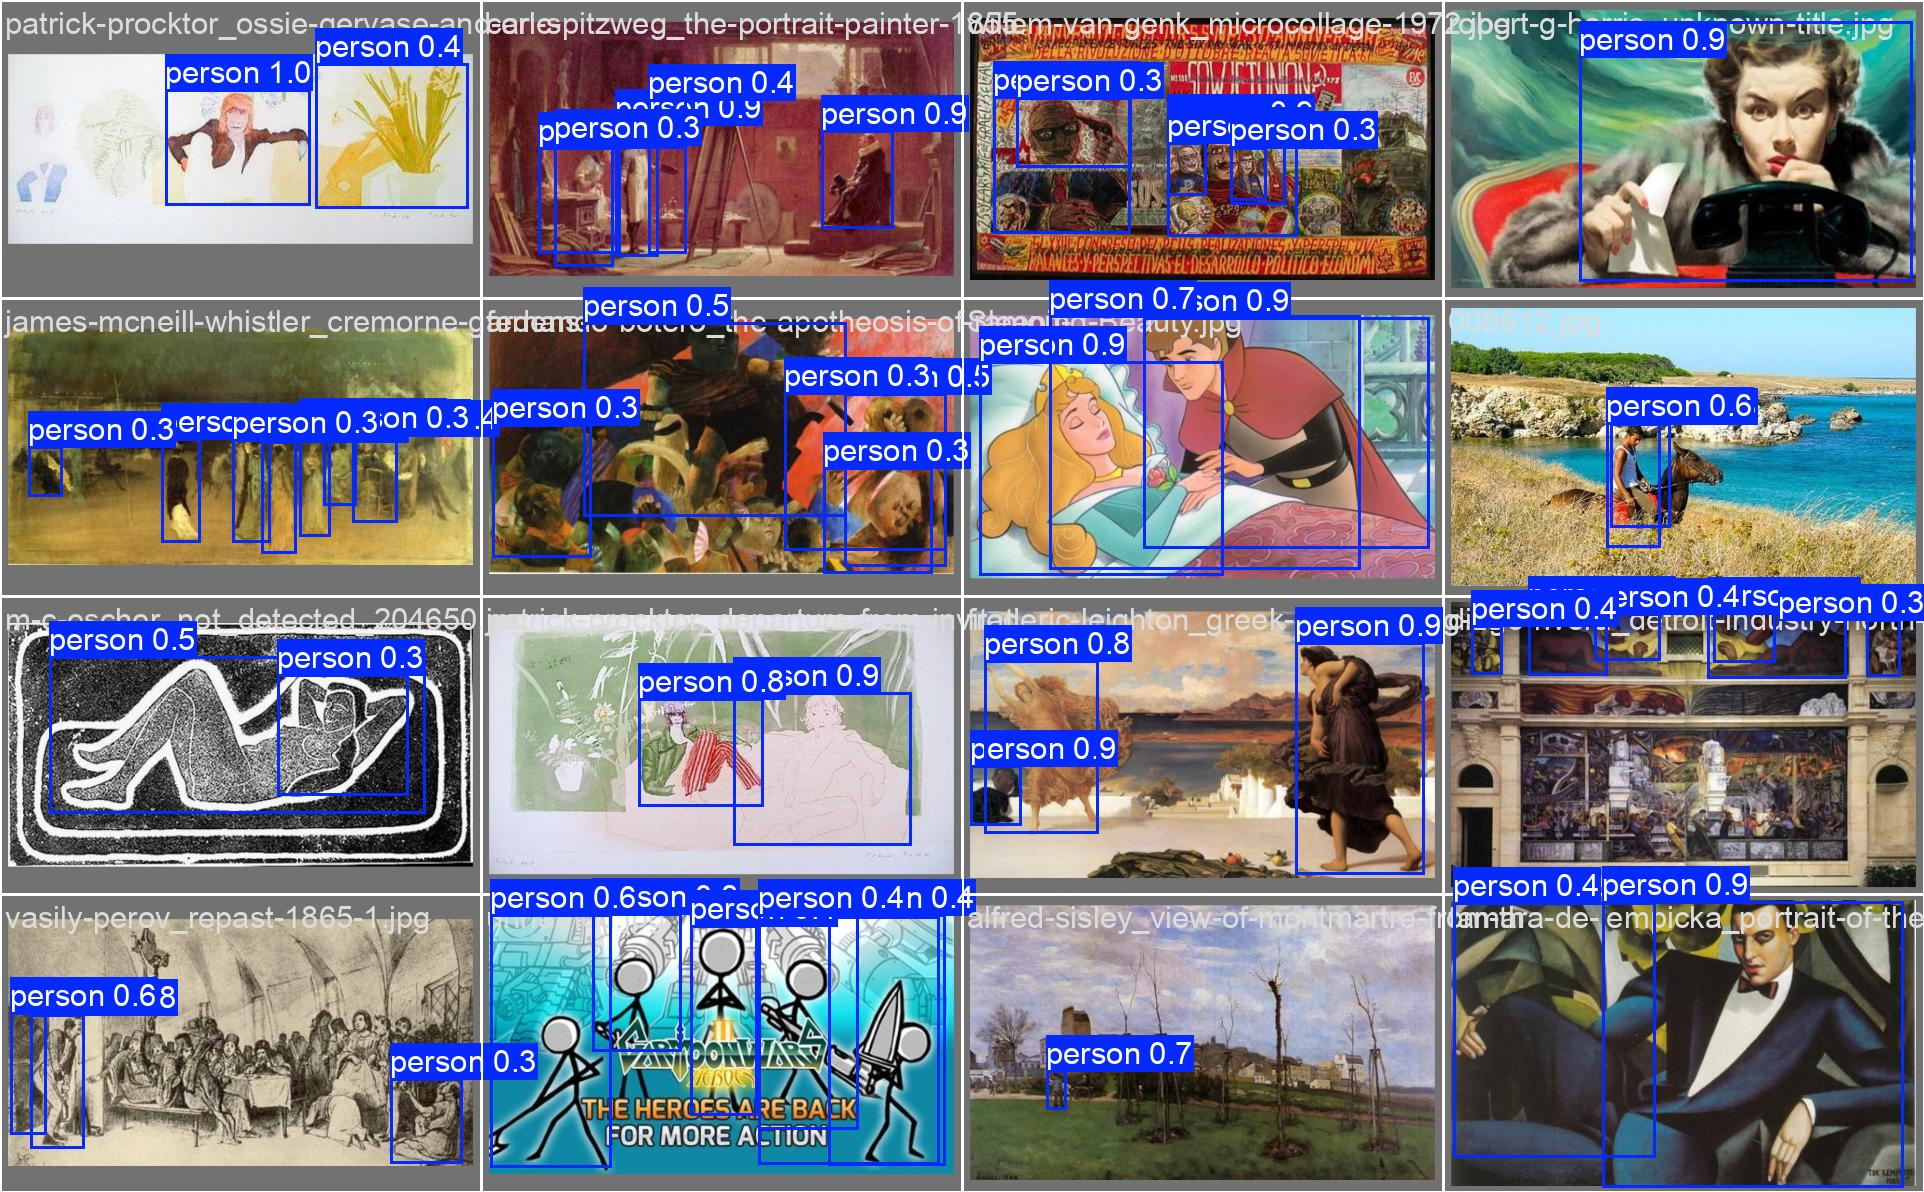

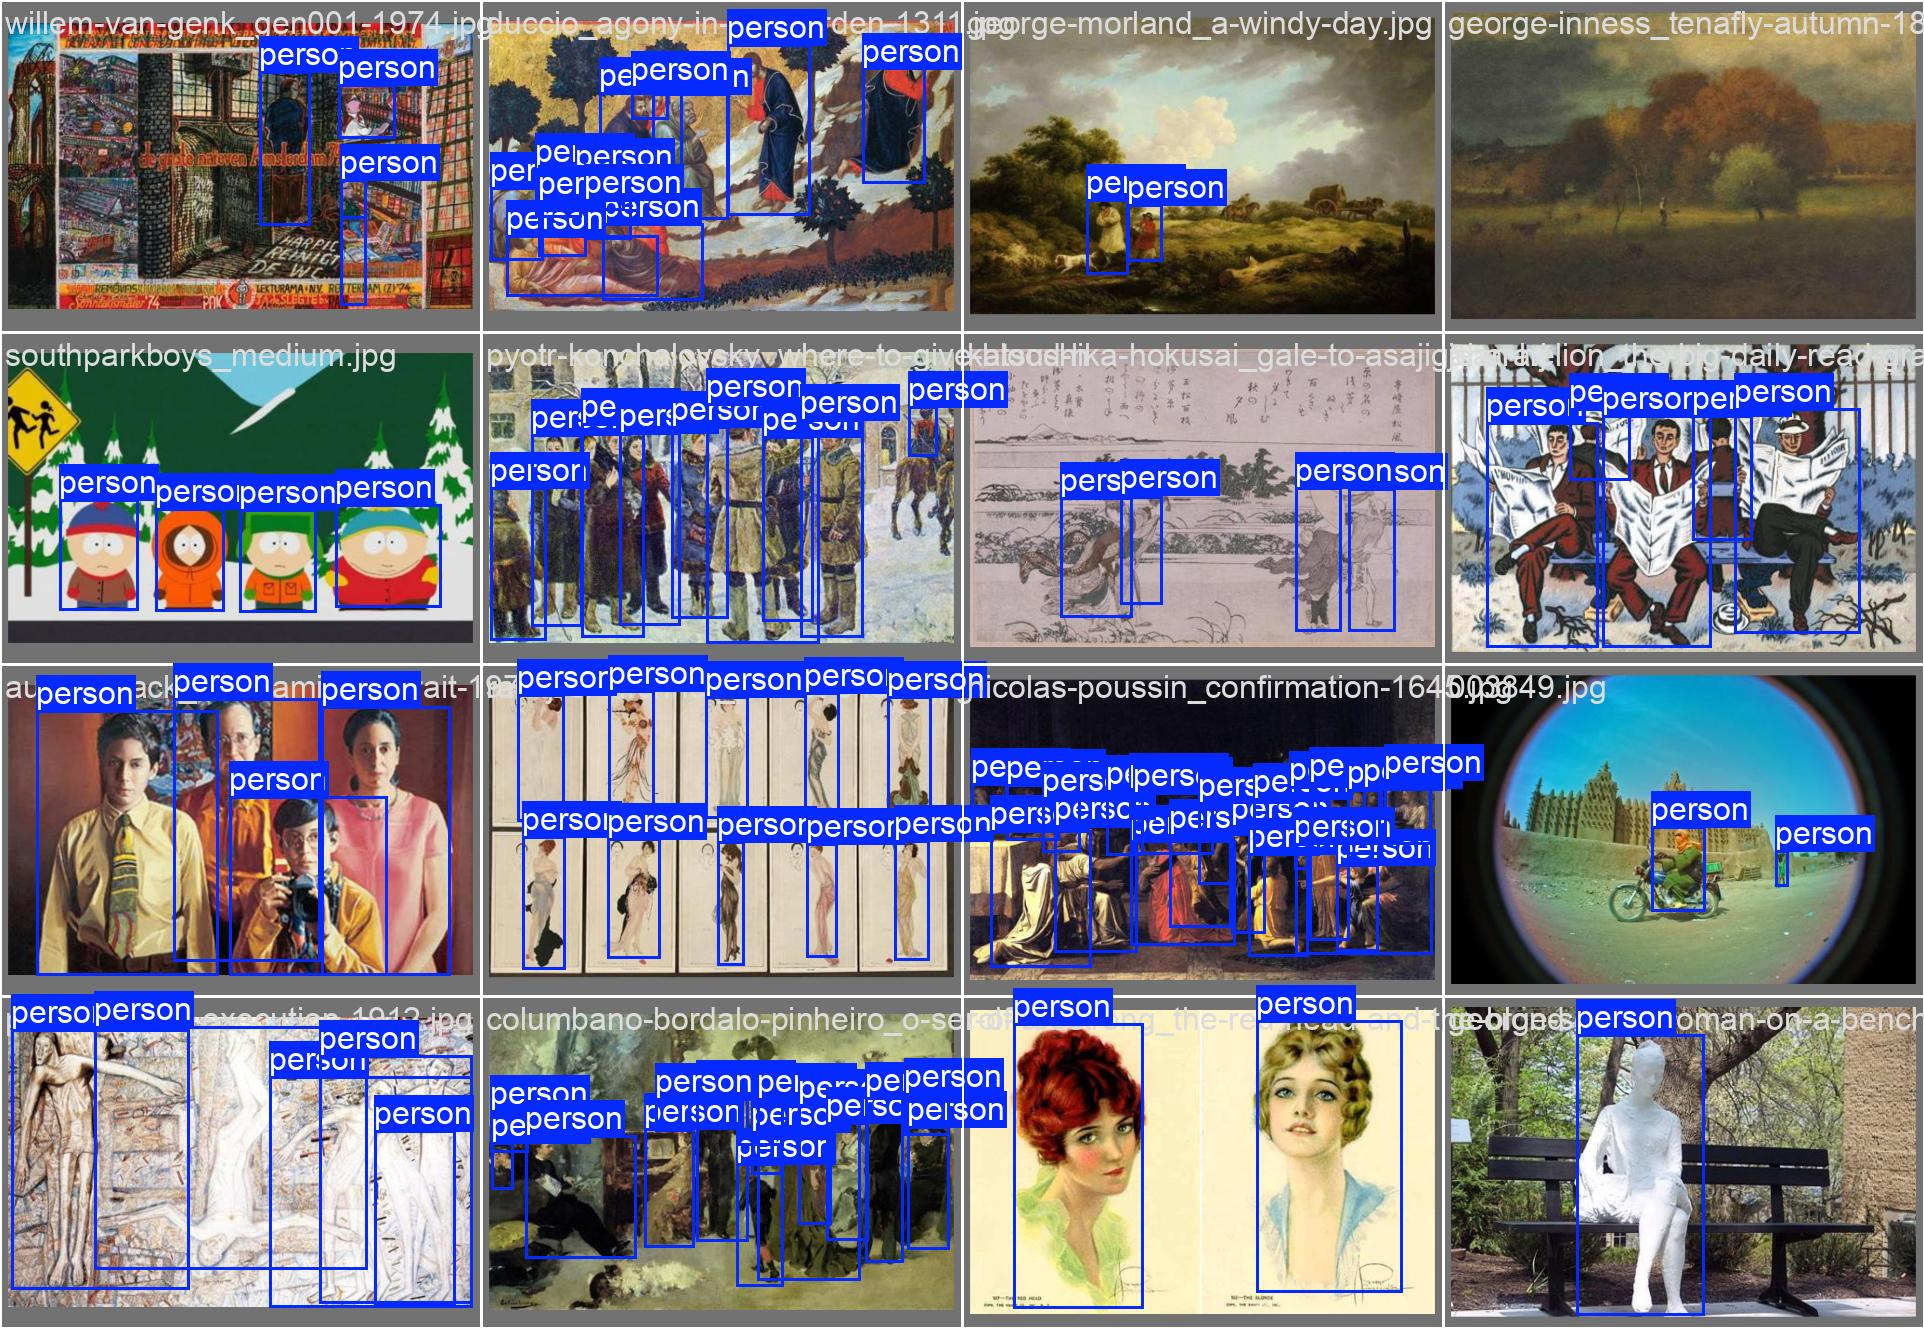

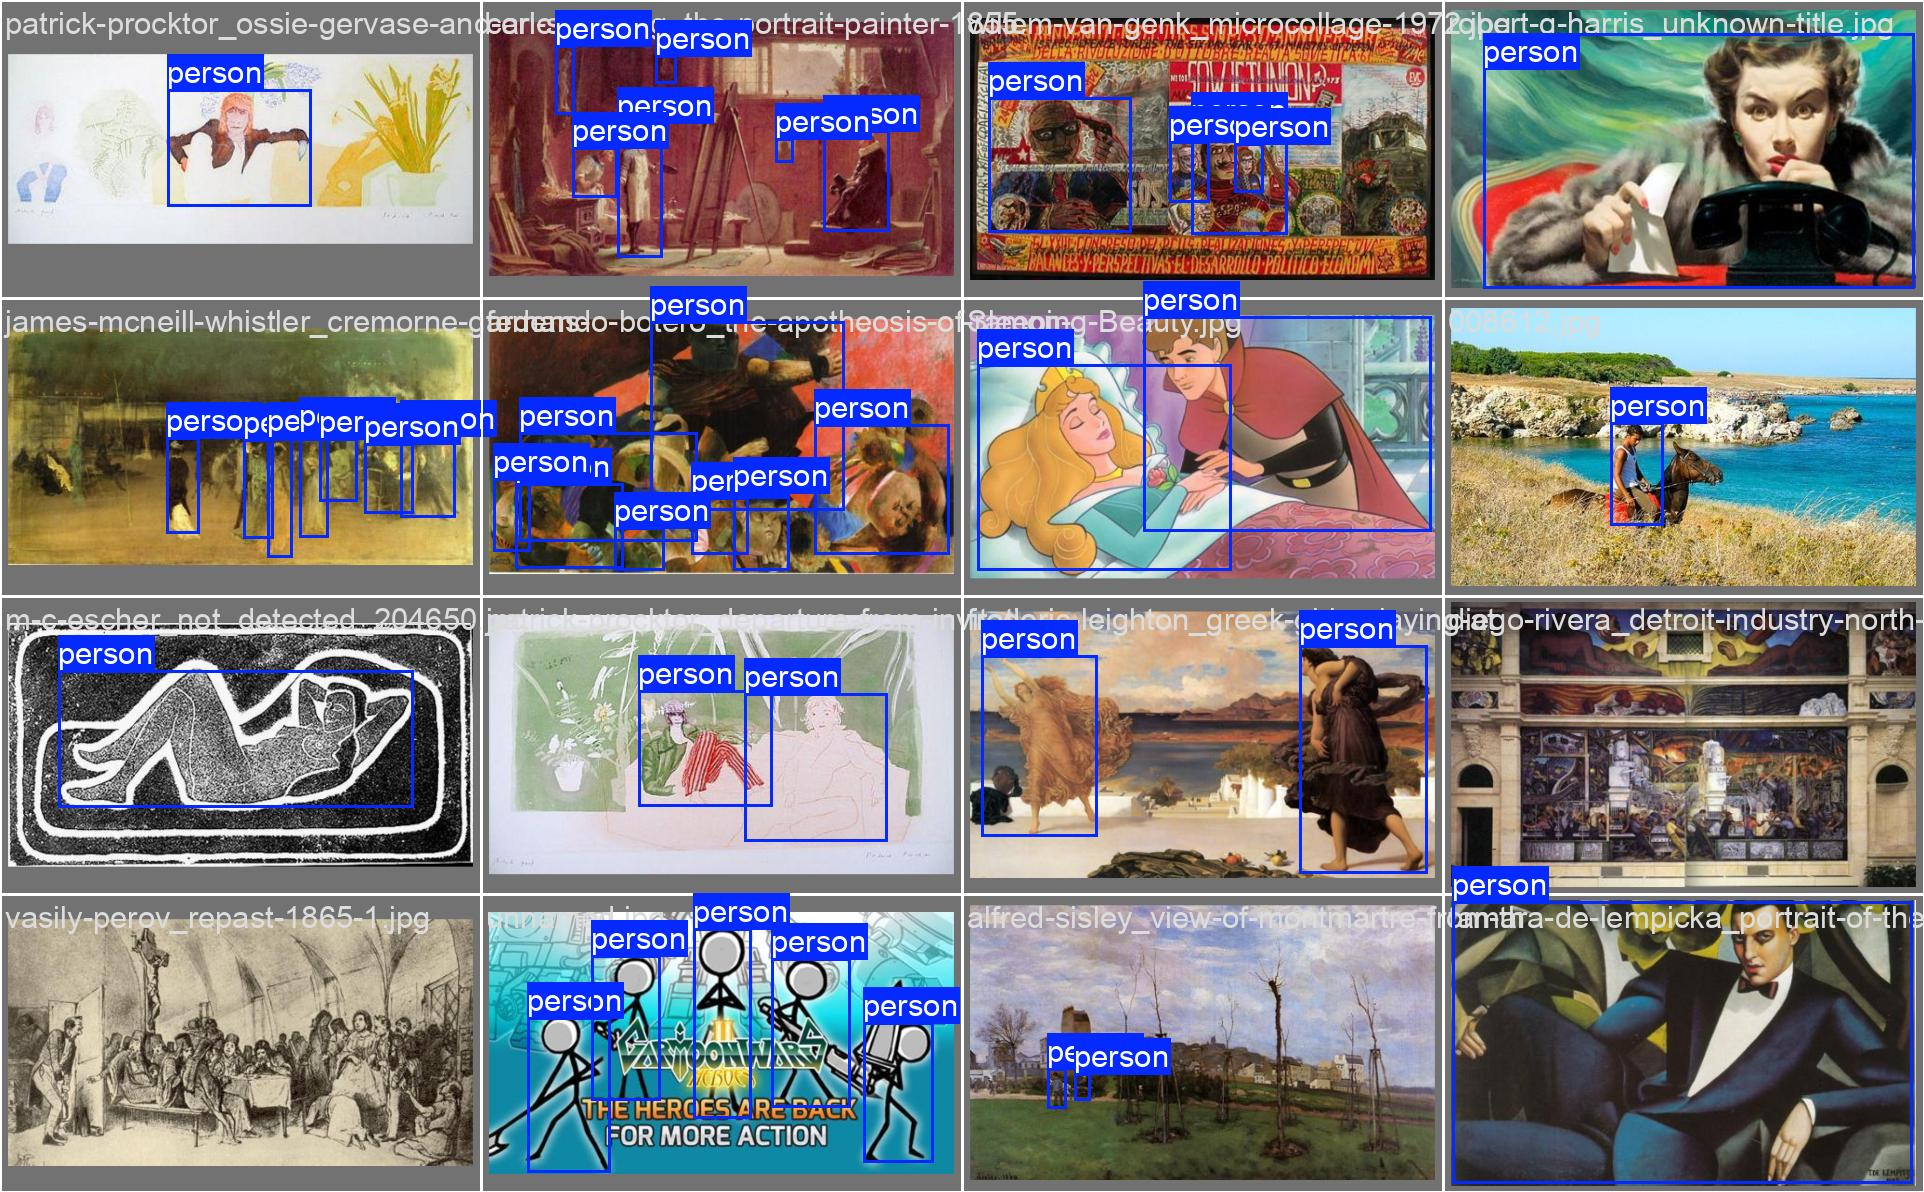

In [ ]:
import os
from IPython.display import Image, display

# Path to val prediction images
val_pred_dir = '/content/runs/detect/train2'  # or 'runs/detect/val' for images

# Display a few images
image_files = [f for f in os.listdir(val_pred_dir) if f.endswith('.jpg')][:5]
for img_file in image_files:
    display(Image(filename=os.path.join(val_pred_dir, img_file)))



image 1/1 /content/PeopleArt/images/val/limbourg-brothers_the-visitation.jpg: 864x896 2 persons, 223.2ms
Speed: 6.5ms preprocess, 223.2ms inference, 2.0ms postprocess per image at shape (1, 3, 864, 896)
Results saved to runs/detect/train3


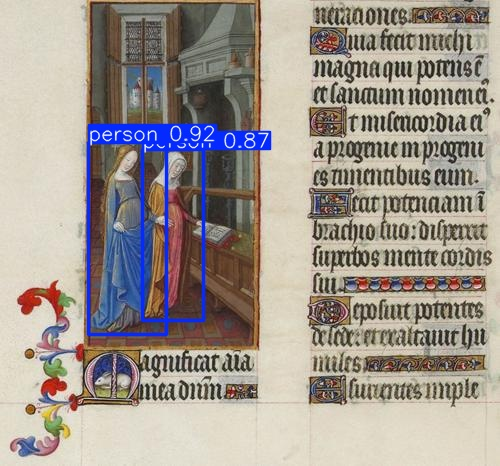


image 1/1 /content/PeopleArt/images/val/Kids-2.jpg: 896x800 16 persons, 212.7ms
Speed: 6.7ms preprocess, 212.7ms inference, 2.8ms postprocess per image at shape (1, 3, 896, 800)
Results saved to runs/detect/train4


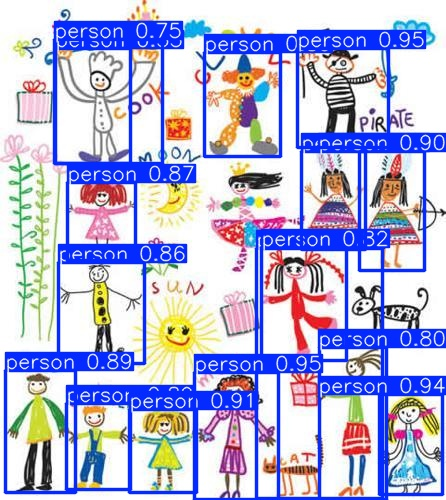


image 1/1 /content/PeopleArt/images/val/kiki-smith_wolf-girl-1999.jpg: 896x672 1 person, 154.9ms
Speed: 6.3ms preprocess, 154.9ms inference, 1.5ms postprocess per image at shape (1, 3, 896, 672)
Results saved to runs/detect/train5


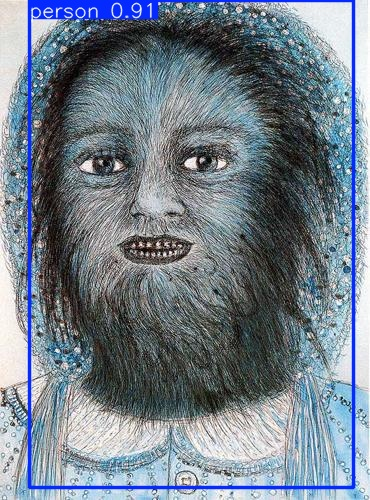

In [ ]:
from PIL import Image
import glob
from pathlib import Path


# Predict on 3 random validation images
for img_path in glob.glob("/content/PeopleArt/images/val/*.jpg")[:3]:
    result = model.predict(img_path, save=True, conf=0.5)
    # Join the save directory string and the filename string
    predicted_image_path = os.path.join(result[0].save_dir, Path(img_path).name)
    display(Image.open(predicted_image_path))

### Test Set

In [ ]:
metrics = model.predict(source="/content/PeopleArt/images/test", save=True)


image 1/145 /content/PeopleArt/images/test/004279.jpg: 672x896 7 persons, 151.3ms
image 2/145 /content/PeopleArt/images/test/004287.jpg: 736x896 1 person, 124.8ms
image 3/145 /content/PeopleArt/images/test/005429.jpg: 608x896 2 persons, 142.9ms
image 4/145 /content/PeopleArt/images/test/51b81f56ee15283311.jpg: 512x896 5 persons, 124.3ms
image 5/145 /content/PeopleArt/images/test/Disney-Valentines-Day-Mulan-Wallpaper.jpg: 672x896 4 persons, 70.3ms
image 6/145 /content/PeopleArt/images/test/Nezha-Conquers-the-Dragon-King2.jpg: 672x896 2 persons, 74.1ms
image 7/145 /content/PeopleArt/images/test/Snow-White-Aurora-Jasmine-disney-princess-17324013-1024-768.jpg: 672x896 4 persons, 71.2ms
image 8/145 /content/PeopleArt/images/test/albrecht-altdorfer_emperor-maximilian-triumphal-1515.jpg: 896x864 5 persons, 103.1ms
image 9/145 /content/PeopleArt/images/test/albrecht-durer_the-holy-family-in-a-room.jpg: 896x768 3 persons, 102.9ms
image 10/145 /content/PeopleArt/images/test/aleksandra-ekster_co

In [ ]:
metrics = model.val(data="/content/PeopleArt/data.yaml", split='test')

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1382.5±254.8 MB/s, size: 50.1 KB)


val: Scanning /content/PeopleArt/labels/test... 145 images, 21 backgrounds, 0 corrupt: 100%|██████████| 145/145 [00:00<00:00, 2251.49it/s]

val: New cache created: /content/PeopleArt/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


                   all        145        282      0.699      0.611      0.679       0.42
Speed: 5.5ms preprocess, 75.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train7


## Final Model

### Save Best Model

In [ ]:
!zip -r best_model.zip runs/detect/train/weights/best.pt

  adding: runs/detect/train/weights/best.pt (deflated 8%)


In [ ]:
from google.colab import files

# Download the zip file
files.download('/content/best_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load Best Model

In [ ]:
from google.colab import files
uploaded = files.upload()  # Select the `best_model.zip` file

Saving best_modelnow.zip to best_modelnow.zip


In [ ]:
!unzip best_modelnow.zip -d best_modelnow/  # Extracts to ``

Archive:  best_modelnow.zip
  inflating: best_modelnow/runs/detect/train/weights/best.pt  


In [ ]:
model_path = '/content/best_modelnow/runs/detect/train/weights/best.pt'

## Gradio Interface

next: chack augmentation, why images change colors after detection, and if other layers are needed (experiment to document)

In [ ]:
import gradio as gr
from PIL import Image
from ultralytics import YOLO
import os
import cv2

# Load the model only once (avoid reloading in reruns)
if 'model' not in globals():
    model = YOLO(model_path)

# Define prediction function
def predict(image):
    results = model(image)
    annotated = results[0].plot()
    annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB) # added this line for the color issue
    return Image.fromarray(annotated)

# Define the interface only once
if 'demo' not in globals():
    demo = gr.Interface(
        fn=predict,
        inputs=gr.Image(type="pil", label="Upload Painting"),
        outputs=gr.Image(type="pil", label="Detected People"),
        title="People Detection in Paintings",
        description="Upload a painting to detect people using YOLOv8.",
        live=False
    )

# Launch in Colab-compatible mode
demo.launch(share=True, inline=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://039a17540162733e9d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



0: 736x896 7 persons, 164.4ms
Speed: 7.5ms preprocess, 164.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 896)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://039a17540162733e9d.gradio.live
